In [1]:
# Libraries

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [29]:
#########################################################################################
#                                      Functions                                        #
#########################################################################################

def import_data(csv_file):
    '''
    Import data and do basic data munging.
    :param csv_file: path to csv file
    :return: df created from csv file
    '''
    # Read csv
    df = pd.read_csv(csv_file,
                     usecols=[1, 2, 5, 6, 7, 8, 11],
                     header=0,
                     names=['PickUpDateTime', 'DropOffDateTime',
                            'PickUpLong', 'PickUpLat',
                            'DropOffLong', 'DropOffLat',
                            'Fare'])
    # Convert pick-up time data to minutes into day
    df['PickUpDateTime'] = pd.to_datetime(df['PickUpDateTime'])
    df['PickUpTime'] = df['PickUpDateTime'].dt.time.astype(str)
    df['PickUpMins'] = df['PickUpTime'].apply(time_to_min)
    # Convert drop-off time data to minutes into day
    df['DropOffDateTime'] = pd.to_datetime(df['DropOffDateTime'])
    df['DropOffTime'] = df['DropOffDateTime'].dt.time.astype(str)
    df['DropOffMins'] = df['DropOffTime'].apply(time_to_min)
    # Calculate trip length
    df['TripTime'] = df['DropOffMins'] - df['PickUpMins']
    df.loc[df['TripTime'] < 0, 'TripTime'] = df['TripTime'] + 24 * 60  # adjust for trips that cross into next day
    df.loc[df['TripTime'] == 0, 'TripTime'] = np.median(df['TripTime'])  # don't trust trips of zero length
    df.loc[df['DropOffMins'] == 0, 'TripTime'] = np.median(
        df['TripTime'])  # don't trust trips with exactly midnight dropoff
    df.loc[df['TripTime'] > 4 * 60, 'TripTime'] = np.median(df['TripTime'])  # don't trust trips longer than 4 hours
    # Clean negative fares
    df.loc[df['Fare'] < 0, 'Fare'] = 0
    # Add lucrativeness = fare/time
    df['FarePerMin'] = df['Fare'] / df['TripTime']
    return df


def create_the_map():
    '''
    Create map object.
    :return: map object for plotting
    '''
    themap = Basemap(projection='merc',
                     llcrnrlon=-74.05,  # lower-left corner longitude
                     llcrnrlat=40.60,  # lower-left corner latitude
                     urcrnrlon=-73.75,  # upper-right corner longitude
                     urcrnrlat=40.90,  # upper-right corner latitude
                     resolution='h') # change to 'h'
    themap.drawcoastlines() #TODO uncomment border drawing just to make report plots, then recomment for code speed
    themap.drawcountries()
    themap.fillcontinents(color = 'white', zorder=0)
    themap.drawmapboundary(fill_color='steelblue')
    return themap

def add_points_to_map(themap, lats, longs, colors):
    '''
    Add scatter points to map plot.
    :param themap: map plotting object
    :param lats: latitudes of points to plot
    :param longs: longitudes of points to plot
    :param colors: color dimension for points
    :return: modify map plotting object in place
    '''
    x, y = themap(longs, lats)
    themap.scatter(x, y, c=colors, cmap=plt.cm.Set1, s=5, lw = 0, alpha=0.5)

def add_cicles_to_the_map(themap, lats, longs, radii, colors):
    '''
    Add circles of specified radii to map plotting object.
    :param themap: map plotting object
    :param lats: latitudes of centers of circles to plot
    :param longs: longitudes of centers of circles to plot
    :param radii: radii of circles in degrees of latitude/longitude
    :param colors: color to plot circles in
    :return: modify map plotting object in place
    '''
    for i in range(len(radii)):
        themap.tissot(longs[i], lats[i], radii[i], 10, alpha=1, color=colors, lw=0)

def n_largest_location_clusters(nlargest, lats, longs, clusters):
    '''
    Get n largest clusters by numbers of observations.
    :param nlargest: number of largest clusters to get
    :param lats: latitudes of rows
    :param longs: longitudes of rows
    :param clusters: clusters of rows
    :return: df with n largest clusters with their location and size
    '''
    # Put data in dataframe for convenience
    df = pd.DataFrame(data={'cluster': clusters,
                            'lat': lats,
                            'long': longs})
    df['mean_lat'] = df.groupby(by='cluster')['lat'].transform('mean') # mean latitude in cluster
    df['mean_long'] = df.groupby(by='cluster')['long'].transform('mean') # mean longitude in cluster
    df['distance_to_mean'] = np.sqrt((df['mean_lat'] - df['lat']) ** 2 + (df['mean_long'] - df['long']) ** 2) # distance to mean
    df['max_distance_to_mean'] = df.groupby(by='cluster')['distance_to_mean'].transform('max') # max distance to mean in cluster
    df['count'] = df.groupby(by='cluster')['cluster'].transform('count') # number of observations in cluster
    df['percent'] = df['count'] / df.shape[0] # percent of observations in cluster
    cluster_cols = ['mean_lat', 'mean_long', 'max_distance_to_mean', 'percent'] # cluster summary df cols
    return df[cluster_cols].drop_duplicates().nlargest(n=nlargest, columns='percent') # n largest clusters data

def n_top_pickup_times(n_largest, mins, clusters):
    '''
    Get n largest clusters by numbers of rows.
    :param n_largest: number of largest clusters to get
    :param mins: time (in minutes of the day) for each row
    :param clusters: clusters of rows
    :return: df with n largest clusters along with the mean time in the day (in minutes)
    '''
    # Put data in dataframe for convenience
    df = pd.DataFrame(data={'clusters': clusters,
                            'mins': mins})
    top_pickup_times_df = df.groupby(by='clusters')['mins'].agg({'mean_mins' : 'mean',
                                                                 'count' : 'count',
                                                                 'min_mins': 'min',
                                                                 'max_mins': 'max'})
    top_pickup_times_df['pickups_per_min'] = top_pickup_times_df['count']/(top_pickup_times_df['max_mins']-top_pickup_times_df['min_mins'])
    top_pickup_times_df['mean_time'] = top_pickup_times_df['mean_mins'].apply(min_to_time)
    return top_pickup_times_df.nlargest(n=n_largest, columns='pickups_per_min')[['mean_time','mean_mins','pickups_per_min','count']]

def time_to_min(x): #
    '''
    Convert time string to minutes in the day int.
    '''
    # Source: http://stackoverflow.com/questions/28845825/pandas-python-convert-hhmmss-into-seconds-in-aggegate-csv-file
    times = x.split(':')
    return (60*int(times[0])+int(times[1]))

def min_to_time(x):
    '''
    Convert minutes in the day int to time string.
    '''
    hour = str(int(x)/60)
    min = str(int(round(x,-1))%60).zfill(2)
    return hour + ':' + min

In [6]:
#########################################################################################
#                                     Main                                              #
#########################################################################################

# Import Data
df = import_data('green_tripdata_2016-03.csv')

In [7]:
# Subset Data
df = df.sample(n=500000, replace=False)

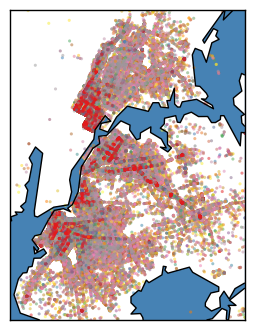

Top 5 locations for trip origins:
          mean_lat  mean_long   percent
745604   40.805082 -73.938810  0.019662
866552   40.746827 -73.890909  0.019344
1087443  40.721292 -73.844311  0.016062
428679   40.690913 -73.991771  0.012732
6713     40.717802 -73.957754  0.011260


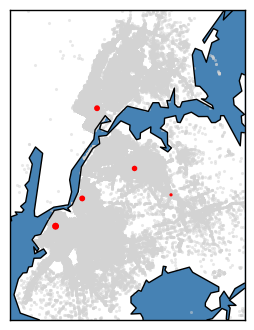

In [14]:
#########################################################################################
# QUESTION 1: What is the time scope of your analysis?                                  #
#########################################################################################

# March 2016 data running on t2.xlarge cluster, randomly selected 200,000 rows

#########################################################################################
# QUESTION 2: What are the top 5 locations which are the origin points of trips?        #
#             What percentage of trips originate from these locations?                  #
#########################################################################################

# Cluster the data
dbscan = DBSCAN(eps=0.00004, min_samples=1)
pickup_clusters = dbscan.fit(df[['PickUpLat', 'PickUpLong']].as_matrix()).labels_
df['PickUpLocClusters'] = pickup_clusters # add to the data frame

# Plot map of all pickup locations colored by cluster
plt.figure()
themap = create_the_map()
add_points_to_map(themap, df['PickUpLat'].values, df['PickUpLong'].values, pickup_clusters)
plt.savefig('q2-1.png', bbox_inches='tight', dpi=300)
plt.show()

# Get data for n largest clusters
largest_pickup_clusters_df = n_largest_location_clusters(5, df['PickUpLat'].values, df['PickUpLong'].values, df['PickUpLocClusters'])

# Print result
print "Top 5 locations for trip origins:"
print largest_pickup_clusters_df[['mean_lat','mean_long','percent']]

# Plot map of n largest clusters
plt.figure()
themap = create_the_map()
add_points_to_map(themap, df['PickUpLat'].values, df['PickUpLong'].values, '#d3d3d3')
add_cicles_to_the_map(themap,
                      lats = largest_pickup_clusters_df['mean_lat'].values,
                      longs=largest_pickup_clusters_df['mean_long'].values,
                      radii=largest_pickup_clusters_df['max_distance_to_mean'].values,
                      colors='red')
plt.savefig('q2-2.png', bbox_inches='tight', dpi=300)
plt.show()


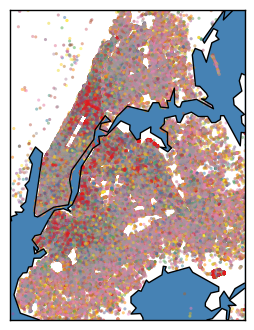

Top 5 locations for trip terminations:
      mean_lat  mean_long   percent
347  40.804980 -73.938818  0.007214
53   40.810179 -73.951144  0.006168
7    40.774192 -73.871860  0.005582
55   40.807981 -73.945193  0.002980
225  40.770541 -73.865103  0.002298


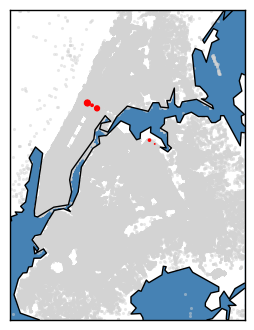

In [18]:
#########################################################################################
# QUESTION 3:  What are the top 5 locations which are the termination points of trips?  #
#              What percentage of trips terminate in these locations?                   #
#########################################################################################

# Cluster the data
dbscan = DBSCAN(eps=0.00006, min_samples=1)
dropoff_clusters = dbscan.fit(df[['DropOffLat', 'DropOffLong']].as_matrix()).labels_
df['DropOffLocClusters'] = dropoff_clusters # add to the data frame

# Plot map of all pickup locations colored by cluster
plt.figure()
themap = create_the_map()
add_points_to_map(themap, df['DropOffLat'].values, df['DropOffLong'].values, dropoff_clusters)
plt.savefig('q3-1.png', bbox_inches='tight', dpi=300)
plt.show()

# Get data for n largest clusters
largest_dropoff_clusters_df = n_largest_location_clusters(5, df['DropOffLat'].values, df['DropOffLong'].values, dropoff_clusters)

# Print result
print "Top 5 locations for trip terminations:"
print largest_dropoff_clusters_df[['mean_lat','mean_long','percent']]

# Plot map of n largest clusters
plt.figure()
themap = create_the_map()
add_points_to_map(themap, df['DropOffLat'].values, df['DropOffLong'].values, '#d3d3d3')
add_cicles_to_the_map(themap,
                      lats = largest_dropoff_clusters_df['mean_lat'].values,
                      longs=largest_dropoff_clusters_df['mean_long'].values,
                      radii=largest_dropoff_clusters_df['max_distance_to_mean'].values,
                      colors='red')
plt.savefig('q3-2.png', bbox_inches='tight', dpi=300)
plt.show()


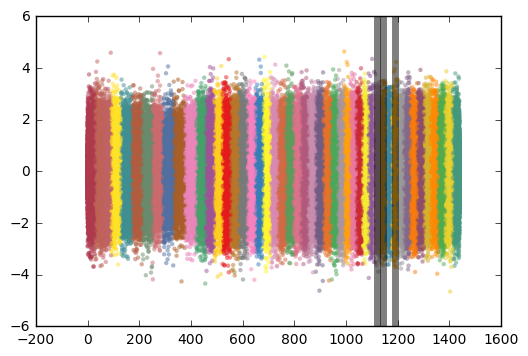

Top 3 pick-up times:
         mean_time  count  pickups_per_min
clusters                                  
45           18:40  12651       602.428571
33           19:00  12939       588.136364
26           19:50  12313       586.333333


In [32]:
#########################################################################################
# QUESTION 4: What are the top 3 time periods of the day generate the most pick-ups?    #
#########################################################################################

# Cluster
minutes = np.reshape(df['PickUpMins'].values, (-1,1))
kmeans = MiniBatchKMeans(n_clusters=48, max_iter=200) # ~30 minutes per cluster
pickup_time_clusters = kmeans.fit(minutes).labels_
df['PickUpTimeClusters'] = pickup_time_clusters

# Get top n=3 times
top_n_pickup_times_df = n_top_pickup_times(3, df['PickUpMins'],df['PickUpTimeClusters'])

# Plot
plt.figure()
events = np.random.normal(loc=0.0, scale=1.0, size=df['PickUpMins'].shape)
plt.scatter(x=df['PickUpMins'], y=events,  c=df['PickUpTimeClusters'], cmap=plt.cm.Set1, s=10, lw = 0, alpha=0.5)
for i in range(len(top_n_pickup_times_df[['mean_mins']])):
    vline = top_n_pickup_times_df['mean_mins'].values[i]
    plt.axvline(vline, alpha=0.5, c='black', lw=5)
plt.savefig('q4.png', bbox_inches='tight', dpi=300)
plt.show()

# Print result
print "Top 3 pick-up times:"
print top_n_pickup_times_df[['mean_time','count','pickups_per_min']]

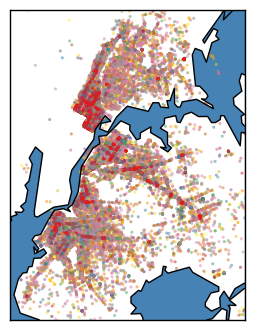

Top 5 locations for lucrative trip origins:
          mean_lat  mean_long
866552   40.746812 -73.890980
1478015  40.721248 -73.844296
523135   40.789542 -73.952460
1511323  40.810429 -73.951987
412825   40.808483 -73.944933


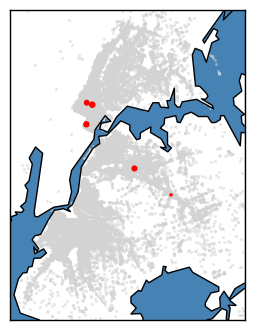

In [33]:
#########################################################################################
# QUESTION 5. If we define lucrative trips as generating the highest fare for least     #
#              amount time spent, what are the                                          #
#              top 5 locations for the origin of the most lucrative trips?              #
#########################################################################################

# Get locations that have the top 20% of most lucrative rides
most_lucrative_df = df[df['FarePerMin'] > df['FarePerMin'].quantile(0.8)].copy()

# Cluster the data
dbscan = DBSCAN(eps=0.0001, min_samples=1)
lucrative_pickup_clusters = dbscan.fit(most_lucrative_df[['PickUpLat', 'PickUpLong']].as_matrix()).labels_
most_lucrative_df['PickUpLocClusters'] = lucrative_pickup_clusters # add to the data frame

# Plot map of all pickup locations colored by cluster
plt.figure()
themap = create_the_map()
add_points_to_map(themap, most_lucrative_df['PickUpLat'].values, most_lucrative_df['PickUpLong'].values, lucrative_pickup_clusters)
plt.savefig('q5-1.png', bbox_inches='tight', dpi=300)
plt.show()

# Get data for n largest clusters
largest_pickup_clusters_df = n_largest_location_clusters(5, most_lucrative_df['PickUpLat'].values,
                                                         most_lucrative_df['PickUpLong'].values,
                                                         most_lucrative_df['PickUpLocClusters'])

# Print result
print "Top 5 locations for lucrative trip origins:"
print largest_pickup_clusters_df[['mean_lat','mean_long']]

# Plot map of n largest clusters
plt.figure()
themap = create_the_map()
add_points_to_map(themap, most_lucrative_df['PickUpLat'].values, most_lucrative_df['PickUpLong'].values, '#d3d3d3')
add_cicles_to_the_map(themap,
                      lats = largest_pickup_clusters_df['mean_lat'].values,
                      longs=largest_pickup_clusters_df['mean_long'].values,
                      radii=largest_pickup_clusters_df['max_distance_to_mean'].values,
                      colors='red')
plt.savefig('q5-2.png', bbox_inches='tight', dpi=300)
plt.show()


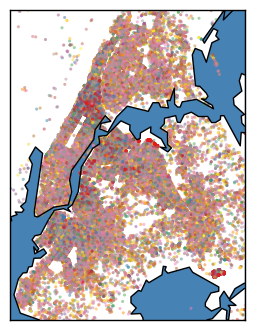

Top 5 locations for lucrative trip terminatinos:
          mean_lat  mean_long
904697   40.774160 -73.871935
1278319  40.804971 -73.938798
390792   40.770542 -73.865106
697719   40.643965 -73.782928
783193   40.768456 -73.861861


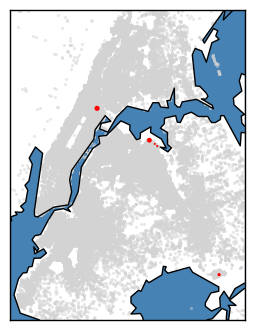

In [36]:
#########################################################################################
# QUESTION 6. If we define lucrative trips as generating the highest fare for least     #
#             amount time spent, what are the                                           #
#             top 5 locations for the termination of trips?                             #
#########################################################################################

# Cluster the data
plt.figure()
dbscan = DBSCAN(eps=0.0001, min_samples=1)
lucrative_dropoff_clusters = dbscan.fit(most_lucrative_df[['DropOffLat', 'DropOffLong']].as_matrix()).labels_
most_lucrative_df['DropOffLocClusters'] = lucrative_dropoff_clusters # add to the data frame

# Plot map of all pickup locations colored by cluster
themap = create_the_map()
add_points_to_map(themap, most_lucrative_df['DropOffLat'].values, most_lucrative_df['DropOffLong'].values, lucrative_dropoff_clusters)
plt.savefig('q6-1.png', bbox_inches='tight', dpi=300)
plt.show()

# Get data for n largest clusters
largest_dropoff_clusters_df = n_largest_location_clusters(5, most_lucrative_df['DropOffLat'].values,
                                                         most_lucrative_df['DropOffLong'].values,
                                                         most_lucrative_df['DropOffLocClusters'])

# Print result
print "Top 5 locations for lucrative trip terminatinos:"
print largest_dropoff_clusters_df[['mean_lat','mean_long']]

# Plot map of n largest clusters
plt.figure()
themap = create_the_map()
add_points_to_map(themap, most_lucrative_df['DropOffLat'].values, most_lucrative_df['DropOffLong'].values, '#d3d3d3')
add_cicles_to_the_map(themap,
                      lats = largest_dropoff_clusters_df['mean_lat'].values,
                      longs=largest_dropoff_clusters_df['mean_long'].values,
                      radii=largest_dropoff_clusters_df['max_distance_to_mean'].values, # scale up for visibility
                      colors='red')
plt.savefig('q6-2.png', bbox_inches='tight', dpi=300)
plt.show()
